In [1]:
import os
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def folder_list(path,label):
    '''
    PARAMETER PATH IS THE PATH OF YOUR LOCAL FOLDER
    '''
    filelist = os.listdir(path)
    review = []
    for infile in filelist:
        file = os.path.join(path,infile)
        r = read_data(file)
        r.append(label)
        review.append(r)
    return review
def read_data(file):
    '''
    Read each file into a list of strings. 
    Example:
    ["it's", 'a', 'curious', 'thing', "i've", 'found', 'that', 'when', 'willis', 'is', 'not', 'called', 'on', 
    ...'to', 'carry', 'the', 'whole', 'movie', "he's", 'much', 'better', 'and', 'so', 'is', 'the', 'movie']
    '''
    f = open(file)
    lines = f.read().split(' ')
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip(), lines)
    # For python 3 users: use the following instead
    words = list(filter(None, words))
#     words = filter(None, words)
    return words

# 4.1
- Load all the data and randomly split it into 1500 training examples and 500 validation exam- ples.


In [3]:
def shuffle_data():
    '''
    pos_path is where you save positive review data.
    neg_path is where you save negative review data.
    '''
    pos_path = "data/pos"
    neg_path = "data/neg"
	
    pos_review = folder_list(pos_path,1)
    neg_review = folder_list(neg_path,-1)
	
    review = pos_review + neg_review
    random.shuffle(review)
    train = review[:1500]
    val = review[-500:]
    return train, val

In [63]:
train,val = shuffle_data()

In [64]:
pickle.dump( train, open( "train.p", "wb" ) )
pickle.dump( val, open( "val.p", "wb" ) )

In [65]:
train = pickle.load(open( "train.p", "rb" ) )
val = pickle.load(open("val.p", "rb"))

# 5.1
- Write a function that converts an example (e.g. a list of words) into a sparse bag-of-words representation.

In [55]:
from collections import Counter
def convert_bag(review):
    cnt = Counter()
    for word in review:
        cnt[word] += 1
    return cnt

In [37]:
def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale

# 6.4

In [281]:
def pegasos(datalist,lambd,max_epoch):
    t = 0
    w = dict() 
    epoch = 0
    while(epoch < max_epoch):
        epoch += 1
        for review in datalist:
            t +=1
            eta = 1/(t * lambd)
            y_i = review[-1]       
            x_i = convert_bag(review[:-1])
            factor = y_i * dotProduct(w, x_i)
            if factor < 1:
                increment(w,(- eta * lambd),w)
                increment(w, eta*y_i,x_i)
            else:
                increment(w,(- eta * lambd),w)
    return w

# 6.5


$\begin{align}
    w_{t+1}&=s_{t+1}W_{t+1}\\\\
    &=(1-\\eta_t \\lambda)s_tW_t+\\eta_t y_j x_j\\\\
    &=(1-\\eta_t \\lambda)w_t+\\eta_t y_j x_j
\end{align}
- so it's equivalent

In [282]:
def scale(w, s):
    for k in w.keys():
        w[k] = w.get(k, 0) * s
    
def pegasos_faster(datalist,lambd, max_epoch):
    t = 0
    s = 1
    W = dict() 
    
    epoch = 0
    while(epoch < max_epoch):
        epoch += 1
        for review in datalist:
            t += 1
            eta = 1/(t * lambd)
            y_i = review[-1]       
            x_i = convert_bag(review[:-1])
            factor = y_i * s * dotProduct(W, x_i)
            s = (1 - eta *lambd) * s
            if s == 0:
                s = 1
                W = dict()

            if factor < 1:
                increment(W,(eta * y_i/s),x_i)
    scale(W, s)
    return W

# 6.6

- I choose epoch = 5 and run two functions, compare the time. The results are as follows, the time spent in the first approach is much more than using the second one. 

In [286]:
%timeit w = pegasos(train, 0.1, 5)

50.5 s ± 852 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [287]:
%timeit w_faster = pegasos_faster(train,0.1, 5)

2.18 s ± 18.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [288]:
a = True
for k,v in w.items():
    if abs(w_faster[k] - w[k]) >1e-6:
        a = False
        print(k)
        break
print(a)

True


##### - From the above cell, we can verify that the two approaches give essentially the same result.

# 6.7

In [195]:
def loss(w,datalist):
    loss = 0
    for review in datalist:
        y_i = review[-1]       
        x_i = convert_bag(review[:-1])
        if dotProduct(w,x_i) * y_i < 0:
            loss += 1
    return loss/len(datalist)

# 6.8

- First, we can observe the approximate number of epochs it need to converge.

In [439]:
epoch_list = np.arange(5,75,5)
w_list = []
for epoch in epoch_list:    
    w = pegasos_faster(train,0.01, epoch)
    w_list.append(w)

In [440]:
loss_train = []
for w in w_list:
    loss_train.append(loss(w,train))

(-0.01, 0.3)

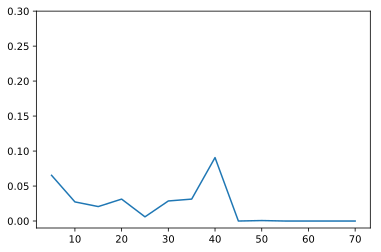

In [441]:
plt.plot(epoch_list,loss_train)
plt.ylim(-0.01,0.3)

- We can see from the plot that it will converge after around 45 epochs, so we can choose epoch=60 in the following searching for the optimum regularization parameter process. We first start with a set of regularization parameters spanning a broad range of orders of magnitude.

In [442]:
lambd_list = [0.001,0.005,0.01,0.02,0.03,0.05,0.08,0.1,0.5,0.75,1]
loss_val = []

for lambd in lambd_list:
    w = pegasos_faster(train,lambd, 60)
    loss_val.append(loss(w,val))
#     print('When epoch={:f}, lambd={:f}, loss = {:f}'.format(epoch, lambd,loss(w, val)))

/Users/jr/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


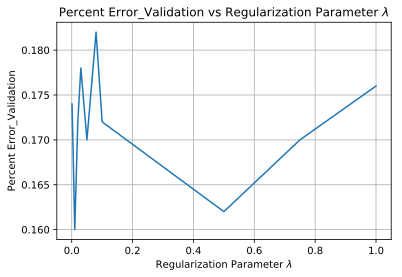

In [443]:
%config InlineBackend.figure_format = 'svg'

fig, ax = plt.subplots()
ax.plot(lambd_list, loss_val)
ax.grid()
ax.set_title("Percent Error_Validation vs Regularization Parameter $\lambda$")
ax.set_xlabel("Regularization Parameter $\lambda$")
ax.set_ylabel("Percent Error_Validation")
fig.show()

- Then we continue to zoom in, observe the percent error with parameter $\lambda$ is within the range of (0.1, 0.75)

In [444]:
lambd_list = np.arange(0.1,0.75,0.05)
loss_val = []

for lambd in lambd_list:
    w = pegasos_faster(train,lambd, 50)
    loss_val.append(loss(w,val))

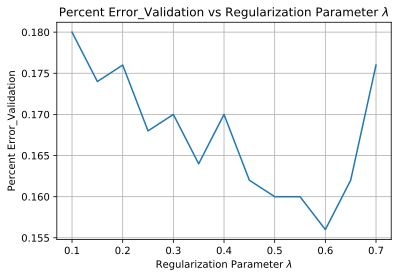

In [445]:
fig, ax = plt.subplots()
ax.plot(lambd_list, loss_val)
ax.grid()
ax.set_title("Percent Error_Validation vs Regularization Parameter $\lambda$")
ax.set_xlabel("Regularization Parameter $\lambda$")
ax.set_ylabel("Percent Error_Validation")
fig.show()

In [446]:
lambd_list = np.arange(0.5,0.65,0.01)
loss_val = []

for lambd in lambd_list:
    w = pegasos_faster(train,lambd, 50)
    loss_val.append(loss(w,val))

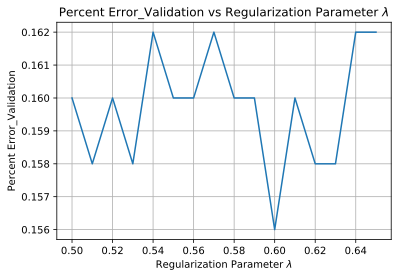

In [447]:
fig, ax = plt.subplots()
ax.plot(lambd_list, loss_val)
ax.grid()
ax.set_title("Percent Error_Validation vs Regularization Parameter $\lambda$")
ax.set_xlabel("Regularization Parameter $\lambda$")
ax.set_ylabel("Percent Error_Validation")
fig.show()

- So we can basically convince ourselves that $\lambda = 0.60$ is the optimum point.

# 7.1

## 7.1.1. choose two input examples that the model got wrong

In [448]:
#choose the optimum regularization parameter $\lambda$ in the above question then
lambd = 0.6
w = pegasos_faster(train,lambd, 50)
num = 0
wrong_egs = []
x_list = []
for review in val:
    y_i = review[-1]       
    x_i = convert_bag(review[:-1])
    if dotProduct(w,x_i) * y_i < 0:
        num += 1
        wrong_egs.append(review)
        x_list.append(x_i)
    if num == 2:
        break  

In [417]:
for count, eg in enumerate(wrong_egs,1):
    x_i = x_list[(count - 1)]
    print('example',count,"\n",' '.join(eg[:-1]))
    print(' ')
    print("The true y value is:",eg[-1], ", but we predict wx as",dotProduct(w,x_i))
    print(' ')


example 1 
 girl 6 is in a word a mess i was never able to determine what spike lee was trying to accomplish with this film there was no sense of where the film was going or any kind of coherent narrative if there was a point to the film i missed it girl 6 by the way is the way theresa randle's character is addressed in the phone sex workplace all the girls are known by their numbers the plot such as it is theresa randle is a struggling n y actress and eventually takes a job as a phonesex operator she begins to lose contact with reality as her job consumes her also she must deal with the advances of her exhusband isiah washington he is an ex con thief and she tries to keep him away while at the same time it's clear that she still harbors feelings for him her neighbor jimmy spike lee functions as the observer mediating between the ex husband and girl 6 he also functions as a point of stability as he watches her become seduced by the lurid world of phone sex the soundtrack consisting of 

For this example, our model predicts it to be a positive one but it's indeed a negative review.

## 7.1.2. create a table of the most important features(sorted by $|w_i x_i|$)

In [420]:
import pandas as pd
df1 = pd.DataFrame(columns=['feature_name','feature_value','feature_weight','product'])
idx = 0
x_i = x_list[0]
for k,v in x_i.items():
    df1.loc[idx] = [k, v, w.get(k,0), abs(w.get(k, 0)* v)]
    idx+=1
df1.sort_values(by=['product'])

,feature_name,feature_value,feature_weight,product
104,mediating,1,0.000000,0.000000
40,randle's,1,0.000000,0.000000
78,isiah,1,0.000000,0.000000
220,multibillion,1,0.000000,0.000000
172,alwaysbroke,1,0.000000,0.000000
45,workplace,1,0.000000,0.000000
154,tafkap,1,0.000000,0.000000
130,transpiring,1,0.000000,0.000000
64,phonesex,2,0.000000,0.000000
246,floundering,1,0.000000,0.000000


In [423]:
pd.set_option('display.max_rows', None)
df1.sort_values(by=['product'])

,feature_name,feature_value,feature_weight,product
104,mediating,1,0.000000,0.000000
40,randle's,1,0.000000,0.000000
78,isiah,1,0.000000,0.000000
220,multibillion,1,0.000000,0.000000
172,alwaysbroke,1,0.000000,0.000000
45,workplace,1,0.000000,0.000000
154,tafkap,1,0.000000,0.000000
130,transpiring,1,0.000000,0.000000
64,phonesex,2,0.000000,0.000000
246,floundering,1,0.000000,0.000000


In [438]:
df2 = pd.DataFrame(columns=['feature_name','feature_value','feature_weight','product'])
idx = 0
x_i = x_list[1]
for k,v in x_i.items():
    df2.loc[idx] = [k, v, w.get(k,0), abs(w.get(k, 0)* v)]
    idx+=1
df2.sort_values(by=['product'])

,feature_name,feature_value,feature_weight,product
104,basquiat,1,0.000000,0.000000
42,almasy,2,0.000000,0.000000
106,kirstin,1,0.000000,0.000000
71,hana,1,0.000000,0.000000
73,binoche,1,0.000000,0.000000
47,burns,1,0.000095,0.000095
77,wartorn,1,0.000095,0.000095
114,crash,1,0.000190,0.000190
41,laszlo,1,0.000286,0.000286
72,juliette,1,0.000476,0.000476


- we can see for example in the first review, the words that set the tone for the whole review such as “mess”, “never able to”, “no sense” can not be shown in the weights or only played a trivial role in the weights, and some words like “loud” and “distracting” also show it’s an negative comment .
- However, positive words such as “excellent” (and also “interesting) appeared with relatively high feature value, but in the context, it appeared as “the only one that stood out was spike lee's buddy character jimmy he was excellent”, which is not a good sign to indicate it’s positive.
- Third, after observing the “feature importance”, we found that most features with high value are neutral. Even if their feature values are small, because of their high frequency, their products turned to be large and may dominate the result.
- One possible solution might be: we can exclude some of the neutral words from the feature list,decrease their impact to the result as possible as we can. And maybe take the negative word that appears before an adjective into consideration when creating features.

# 6.9
- generate absolute score for each review in validation set(to present magnitude)

In [453]:
df3 = pd.DataFrame(columns=['actual y','score','abs_score'])
idx = 0
for review in val:
    y_i = review[-1]       
    x_i = convert_bag(review[:-1])        
    score = dotProduct(w,x_i)
    abs_score = abs(score)
    df3.loc[idx] = [y_i, score,abs_score]
    idx+=1
df4 = df3.sort_values(by=['abs_score'])
df4

,actual y,score,abs_score
406,-1.0,-0.001022,0.001022
141,1.0,0.002800,0.002800
317,1.0,0.003311,0.003311
435,-1.0,-0.010022,0.010022
409,-1.0,-0.010200,0.010200
96,1.0,-0.022178,0.022178
389,1.0,-0.022556,0.022556
471,-1.0,-0.026333,0.026333
91,1.0,0.033289,0.033289
251,1.0,-0.033956,0.033956


- create a function to return a table for a given number of groups that the validation will be split into.

In [498]:
def table_percentage_error_group(group_num):
    df5 = pd.DataFrame(columns=['magnitude_score','percentage error'])
    idx = 0
    for group in np.array_split(df4, group_num):
        average_abs_score = group['abs_score'].sum(axis=0)/(500/group_num)
        loss = 0
        for i in group['score']:
            y = group.loc[group['score'] == i]['actual y'].values
            if y * i <0:
                loss +=1
        avg_loss = loss/50
        df5.loc[idx] = [average_abs_score, avg_loss]
        idx +=1
    return df5

- show the result as following:
- I found that there is a correlation between higher magnitude scores and accuracy（although there is some fluctuation)the overall trend is: the higher the magnitude scores , the lower the precentage error is, i.e. the higher the accuracy is.

In [499]:
table_percentage_error_group(5)

,magnitude_score,percentage error
0,0.127975,0.70
1,0.318731,0.52
2,0.572055,0.22
3,0.945051,0.08
4,1.789378,0.04


In [500]:
table_percentage_error_group(10)

,magnitude_score,percentage error
0,0.072798,0.28
1,0.183152,0.42
2,0.263439,0.22
3,0.374024,0.30
4,0.506593,0.18
5,0.637516,0.04
6,0.819903,0.04
7,1.070199,0.04
8,1.377315,0.02
9,2.201440,0.02


In [501]:
table_percentage_error_group(20)

,magnitude_score,percentage error
0,0.039524,0.14
1,0.106072,0.14
2,0.162456,0.22
3,0.203849,0.20
4,0.241499,0.12
5,0.285379,0.10
6,0.340310,0.10
7,0.407737,0.20
8,0.480252,0.08
9,0.532935,0.10


# 6.10

In [502]:
def scale(w, s):
    for k in w.keys():
        w[k] = w.get(k, 0) * s
    
def pegasos_faster_count(datalist,lambd, max_epoch):
    t = 0
    s = 1
    W = dict() 
    count = 0
    epoch = 0
    while(epoch < max_epoch):
        epoch += 1
        for review in datalist:
            t += 1
            eta = 1/(t * lambd)
            y_i = review[-1]       
            x_i = convert_bag(review[:-1])
            factor = y_i * s * dotProduct(W, x_i)
            s = (1 - eta *lambd) * s
            if s == 0:
                s = 1
                W = dict()

            if factor < 1:
                increment(W,(eta * y_i/s),x_i)
            elif factor ==1:
                count += 1
#     scale(W, s)
    return count


In [505]:
pegasos_faster_count(train,0.6,50)

0

we found $y_i w^T x_i = 1$ did not appear

In [513]:
def scale(w, s):
    for k in w.keys():
        w[k] = w.get(k, 0) * s
    
def pegasos_faster_count(datalist,lambd, max_epoch):
    t = 0
    s = 1
    W = dict() 
    count = 0
    epoch = 0
    while(epoch < max_epoch):
        epoch += 1
        for review in datalist:
            t += 1
            eta = 1/(t * lambd)
            y_i = review[-1]       
            x_i = convert_bag(review[:-1])
            factor = y_i * s * dotProduct(W, x_i)
            s = (1 - eta *lambd) * s
            if s == 0:
                s = 1
                W = dict()

            if factor < 1:
                increment(W,(eta * y_i/s),x_i)
            elif abs(factor - 1)<1e-4:
                count += 1
#     scale(W, s)
    return count


In [514]:
pegasos_faster_count(train,0.6,50)

8

But when I set a small distance($0.0001$) of $y_i w^T x_i$ from 1, I found that within 50 epochs, this appeared 8 times.